In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h3
import folium
plt.style.use('seaborn-v0_8-whitegrid')
plt.style.use('ggplot')


In [2]:
df_offer = pd.read_csv("./data/datasets/data_offers.csv")
df_order = pd.read_csv("./data/datasets/data_orders.csv")

## (1)

In [3]:
df_order["order_hour"] = pd.to_datetime(df_order["order_datetime"],format='%H:%M:%S')
df = df_order.groupby(["order_status_key","is_driver_assigned_key"]).count().reset_index()
df

,order_status_key,is_driver_assigned_key,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,cancellations_time_in_seconds,order_hour
0,4,0,4496,4496,4496,0,4496,4496,4496
1,4,1,2811,2811,2811,2811,2811,2811,2811
2,9,0,3406,3406,3406,0,3406,0,3406
3,9,1,3,3,3,3,3,0,3


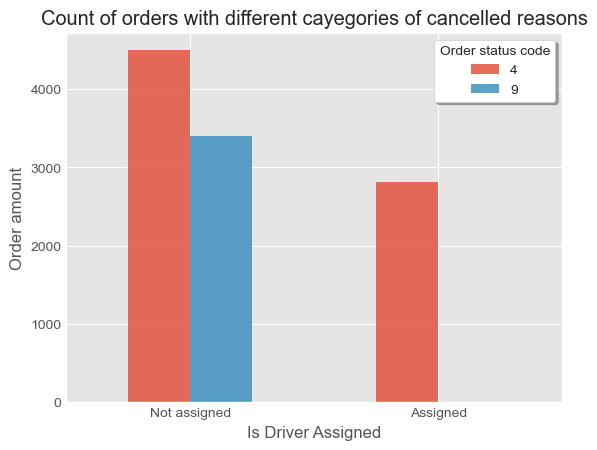

In [5]:
pivot_df = df.pivot(index='is_driver_assigned_key', columns='order_status_key', values='order_gk')

ax = pivot_df.plot(kind='bar', legend=True,stacked=False,alpha=0.8)
ax.set_xticklabels(["Not assigned","Assigned"],rotation=0)

plt.xlabel('Is Driver Assigned')
plt.ylabel('Order amount')
plt.title('Count of orders with different cayegories of cancelled reasons')
plt.legend(title="Order status code",facecolor= 'white',frameon=True,shadow=True)
plt.show()
plt.close()


#### Conclusions
The category with status cancelled by client and is not assigned with drivers has the highest amount of orders.

## (2)

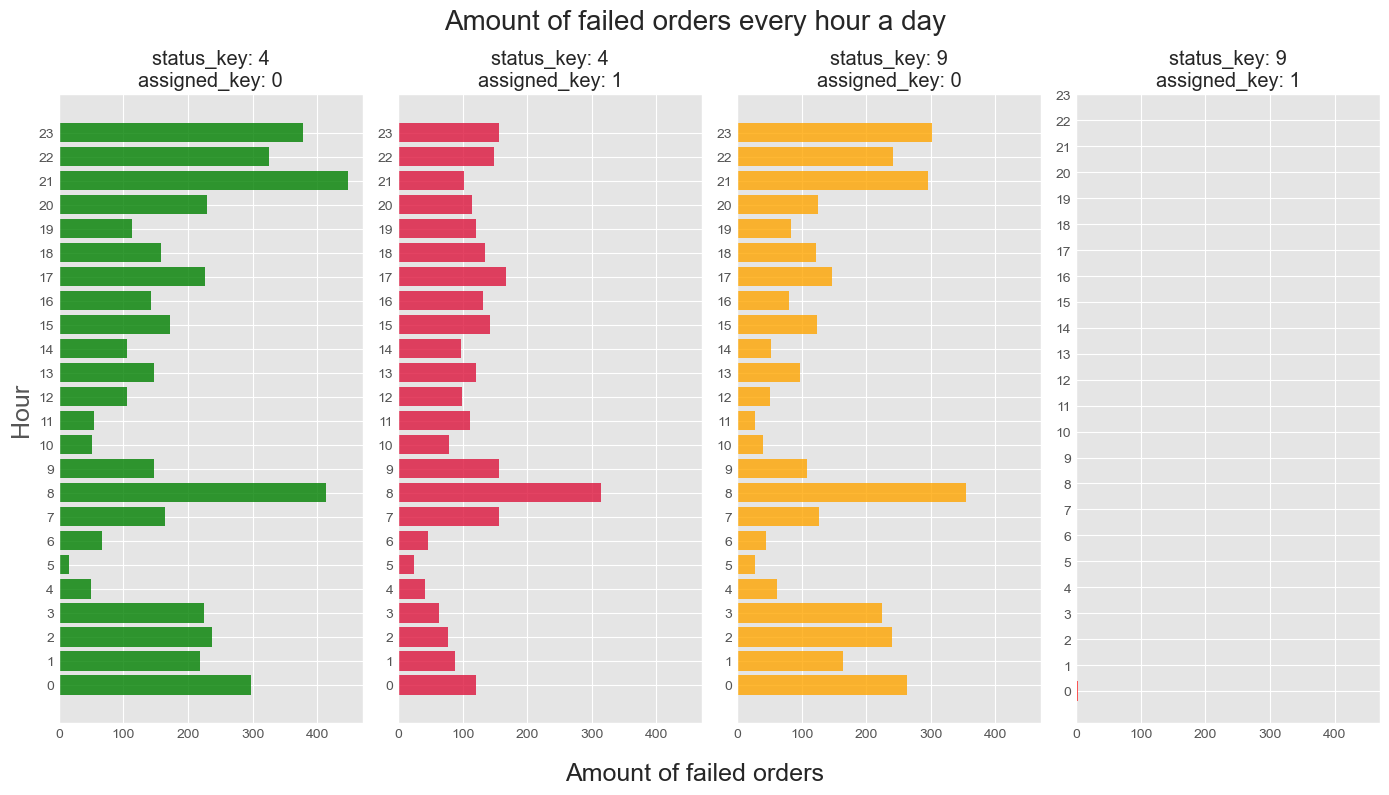

In [79]:
df = df_order
df['order_times'] = df["order_hour"].dt.hour

groups = df.groupby(["order_status_key", "is_driver_assigned_key"])

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 8),sharex='all')
colors = ['green','crimson','orange','red']
for i, ((status_key, assigned_key),ax) in enumerate(zip(groups.indices,axes)):

    grouped_df = groups.get_group((status_key,assigned_key))
    grouped_df = grouped_df.groupby("order_times").count().reset_index()
    ax.barh(grouped_df['order_times'],grouped_df['order_gk'],color=colors[i],alpha=0.8)
    ax.set_yticks(range(24))
    ax.set_title(f'status_key: {status_key}\nassigned_key: {assigned_key}')
    if i == 0:
        ax.set_ylabel('Hour',fontsize=18)
    #ax.set_xlabel('Amount of failed orders')

fig.suptitle('Amount of failed orders every hour a day', fontsize=20) 
fig.supxlabel('Amount of failed orders',fontsize=18)
plt.tight_layout()
plt.show()

### Findings
- `Categorically abnormal distribution` 
    - Most failed orders come from cancellations by clients.
- `Biggest fail hour` 
    - In morning at 8 o'clock to 9 o'clock, there are more failed orders than the other time.
- `Reason` 
    - Since in morning at 8 is the rush hour of daily commute. So There are usually more orders from citizens. System will not reject too many orders since they want to make profit in the common sense. Thus most cancellations come from clients.

## (3)

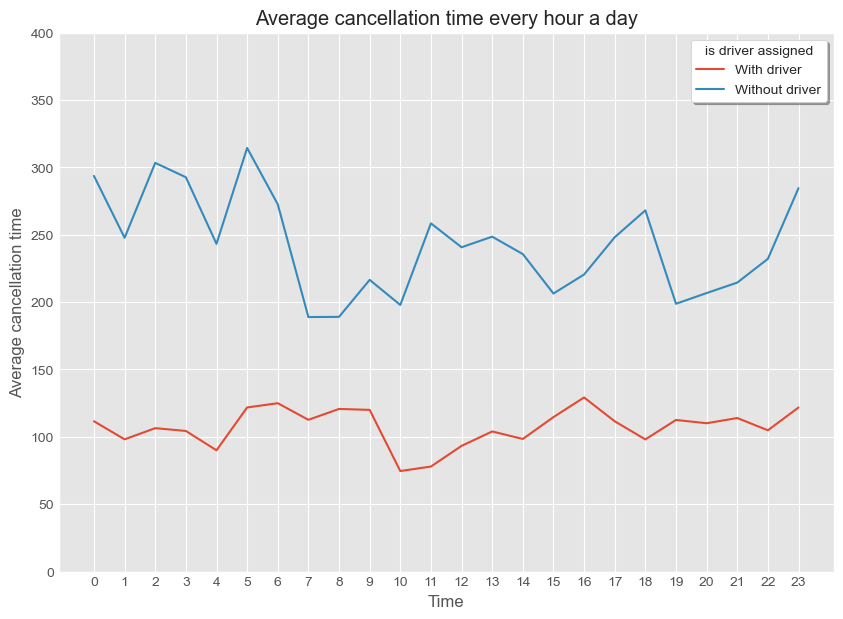

In [8]:
df = df_order
df['order_times'] = df["order_hour"].dt.hour
df_mean_cancel = df.groupby(['order_times','is_driver_assigned_key'])['cancellations_time_in_seconds'].mean().reset_index()
fig, ax = plt.subplots(figsize=(10,7))
groups = df_mean_cancel.groupby('is_driver_assigned_key')
ax.plot(groups.get_group(0)["order_times"],groups.get_group(0)['cancellations_time_in_seconds'],label='With driver')
ax.plot(groups.get_group(1)["order_times"],groups.get_group(1)['cancellations_time_in_seconds'],label='Without driver')
ax.set_xticks(range(24))
plt.xlabel('Hour')
plt.ylabel('Average cancellation time')
plt.title('Average cancellation time every hour a day')
plt.legend(title="is driver assigned",facecolor= 'white',frameon=True,shadow=True)
plt.ylim(0,400)
plt.show()
plt.close()

### Findings & Explainations
This plot tells us when driver is not assigned to a client, it usually takes more time to cancel it for him(or her). Since clients pursue driver assignment, they are willing to wait for offers.

## (4)

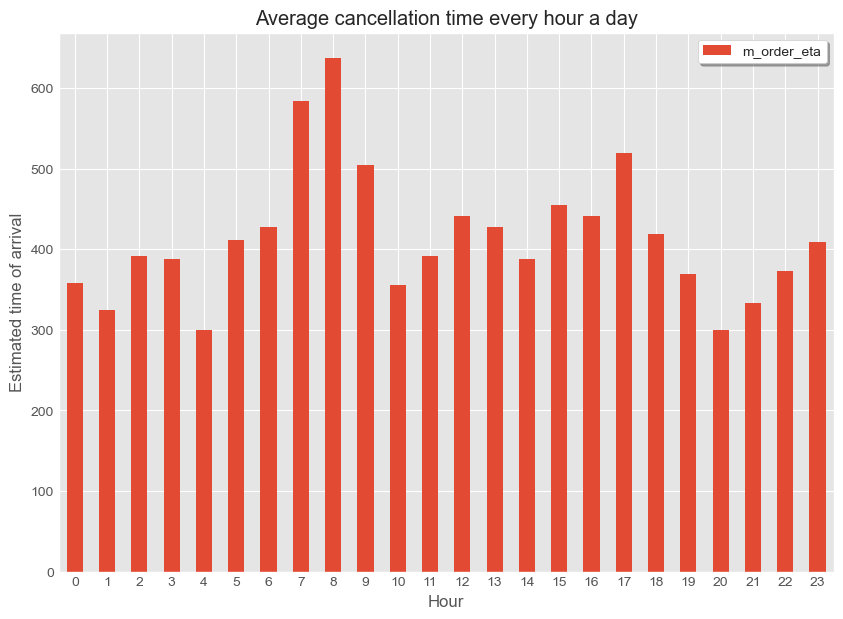

In [9]:

df_avg_eta = df.groupby('order_times')['m_order_eta'].mean()

ax = df_avg_eta.plot(kind='bar',figsize=(10,7),legend=True,stacked=False)
ax.set_xticklabels(labels= [x for x in range(24)],rotation=0)

plt.xlabel('Hour')
plt.ylabel('Estimated time of arrival')
plt.title('Average cancellation time every hour a day')
plt.legend(frameon=True,facecolor='white',shadow=True)
plt.show()
plt.close()

### Explaination
Since 7 to 9 o'clock in morning and 5 o'clock in afternoon are the rush hours of a day, the traffic jams are common situation and it takes more time for drivers to pick up the clients.

## (5)

In [10]:
resolution = 8

df['hex_id'] = df.apply(lambda x: h3.geo_to_h3(x['origin_latitude'], x['origin_longitude'], resolution) , axis=1)

hex_counts = df.groupby('hex_id').agg(orders=('hex_id', 'count')).reset_index()

hex_counts = hex_counts.sort_values("orders",ascending=False)
hex_counts


,hex_id,orders
97,88195d2b1dfffff,1497
96,88195d2b1bfffff,870
93,88195d2b15fffff,774
91,88195d2b11fffff,707
95,88195d2b19fffff,667
...,...,...
7,88195d281dfffff,1
8,88195d2821fffff,1
59,88195d2a1bfffff,1
142,88195d74d5fffff,1


In [11]:
#fhex_counts = hex_counts.sort_values("order_gk")
hex_counts['order_percentage'] = hex_counts['orders'].cumsum() / hex_counts['orders'].sum()
hex_counts['color_weights'] =  hex_counts['orders'] / hex_counts['orders'].max()

top_hexes = hex_counts[hex_counts['order_percentage'] <= 0.8]

down_hexes = hex_counts[hex_counts['order_percentage'] > 0.8]

print(f"The amount of size 8 hexes which contain about 80% of all orders is {top_hexes.shape[0]}")
top_hexes


The amount of size 8 hexes which contain about 80% of all orders is 23


,hex_id,orders,order_percentage,color_weights
97,88195d2b1dfffff,1497,0.139698,1.000000
96,88195d2b1bfffff,870,0.220885,0.581162
93,88195d2b15fffff,774,0.293113,0.517034
91,88195d2b11fffff,707,0.359089,0.472278
95,88195d2b19fffff,667,0.421333,0.445558
20,88195d284dfffff,653,0.482270,0.436206
63,88195d2a27fffff,414,0.520903,0.276553
89,88195d2b0bfffff,372,0.555618,0.248497
62,88195d2a25fffff,362,0.589399,0.241817
92,88195d2b13fffff,346,0.621687,0.231129


In [12]:
def colorMap(weight:int):
    weight = round((1.1 - weight) * 255)#Here use 1.1 since 00 is total black
    mapped_color = hex(weight)[2:4]
    return "#DC" + mapped_color + "3C"
#Since 00 is the darkest and FF is the brightest , using weights of the max value to derive corresponding color

In [13]:

map_center = df[['origin_latitude', 'origin_longitude']].mean().values.tolist()
m = folium.Map(location=map_center, zoom_start=12)


for index, row in top_hexes.iterrows():
    hex_boundary = [(x[0],x[1]) for x in h3.h3_to_geo_boundary(row["hex_id"])]
    folium.Polygon(locations=hex_boundary,
    smooth_factor=2,
    color="black",
    tooltip="Contains about 80 percent orders",
     fill=True, fill_color=colorMap(row["color_weights"]), fill_opacity=0.5
).add_to(m)
    
for index, row in down_hexes.iterrows():
    hex_boundary = [(x[0],x[1]) for x in h3.h3_to_geo_boundary(row["hex_id"])]
    folium.Polygon(locations=hex_boundary,
    smooth_factor=2,
    color="black",
    tooltip="Contains about 20 percent orders",
    weight=1,
     fill=True, fill_color="green", fill_opacity=0.5
).add_to(m)

In [14]:
m.save('map.html')

In [15]:
m

### Conclusions 
There are 23 hexes containing the 80% of orders. And the map are shown above.